In [1]:
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics

import matplotlib.pyplot as plt

C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\envs\Pytorchgpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import re
from tqdm import tqdm
from string import punctuation
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
nltk.download('wordnet')
from gensim.models.fasttext import FastText
lemma = WordNetLemmatizer()
stop_words=stopwords.words('english')

# stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
# from fasttext import load_model
from nltk.tokenize import RegexpTokenizer 
from sklearn.preprocessing import MultiLabelBinarizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,SpatialDropout1D,LSTM,Bidirectional
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils as np_utils
from tensorflow.python.client import device_lib 

print(device_lib.list_local_devices())
from IPython.display import display, HTML

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6699302215586433560
]


In [4]:
train_df=pd.read_csv('./project/training_data.csv')
test_df=pd.read_csv('./project/testing_data.csv')

In [5]:
train_df

,title,category
0,The Three Amigos,None
1,Home Essentials Blue Floral Glass Vintage Styl...,Home & Kitchen
2,Cooper Wiring Quiet Toggle Switch Single Pole ...,Tools & Home Improvement
3,Baseboarders&reg; Wall Brackets,Tools & Home Improvement
4,The Great Wave Off Kanagawa Custom Rectangle M...,Office Products
...,...,...
20183,D0309-WML Leviton Decora Screwless Snap-On Wal...,None
20184,South Shore Axess Small 2-Door Storage Cabinet...,None
20185,Patriotic Flip Flop Ornament Assortment of 2,Home & Kitchen
20186,Cybrtrayd Life of the Party A116 Horse Chocola...,None


In [6]:
# label encoding with maintaining dimension
label_df=train_df[train_df['category']!='None']

label_df['category_label']=label_df['category'].factorize()[0]
unlabeled_df=train_df[train_df['category']=='None']

print('category: ',label_df['category'].unique())


category_id_df = label_df[['category', 'category_label']].drop_duplicates()
category_id_df

y=label_df['category_label']
y = np_utils.to_categorical(y, num_classes=6)

category_list=category_id_df['category'].tolist()
num_classes = len(category_list)
print('no of classes:', num_classes)

category:  ['Home & Kitchen' 'Tools & Home Improvement' 'Office Products'
 'Grocery & Gourmet Food' 'Electronics' 'Industrial & Scientific']
no of classes: 6


<ipython-input-6-76e12f3164d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['category_label']=label_df['category'].factorize()[0]


## Text Preprocessing 

In [7]:
def text_normalize(text):
    
    # remove special characters\whitespaces
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text), re.I | re.A)
    # convert to lower 
    clean_text=text.lower()
    
    # Remove extra white space from text
    clean_text = re.sub(r'\s+', ' ', clean_text, flags=re.I)
         
    # Remove all the special characters from text
    clean_text = re.sub(r'\W', ' ', str(clean_text))
    
    clean_text = re.sub(r'\d', ' ', str(clean_text))
    
    # Word tokenization       
    tokens = clean_text.split()
    
    
    stop_word = set(stopwords.words('english')) | set(punctuation)| set(ENGLISH_STOP_WORDS)
    
    # re-create text from filtered lemmatize tokens
    cleaned_text = ' '.join(lemma.lemmatize(token) for token in tokens if token not in stop_word)
    
    return cleaned_text


## Training Fasttext Model 



In [8]:
title_list=train_df['title'].tolist()
clean_corpus = [text_normalize(sentence) for sentence in  title_list if sentence.strip() !='']
word_tokenizer = nltk.WordPunctTokenizer()

word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_corpus)]
print(word_tokens[1])

# Defining values for parameters
embedding_size = 300
window_size = 3
min_word = 3
down_sampling = 1e-2
 

fast_Text_model = FastText(word_tokens,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,epochs=10)

# # Save fastText gensim model

# fast_Text_model.save("./models/fasttext_train")

# # Load saved gensim fastText model
fast_Text_model =FastText.load("models/fasttext_train")


100%|█████████████████████████████████████████████████████████████████████████| 20188/20188 [00:00<00:00, 71202.58it/s]


['home', 'essential', 'blue', 'floral', 'glass', 'vintage', 'style', 'water', 'goblet', 'set']


## Creating Embeddings


In [9]:
def get_embedding(word):
    try:
        embedding=fast_Text_model.wv[word]
    except:
        pass
#         embedding=np.zeros((300,)) 
        
    return embedding

In [10]:
embeddings_index = {}
vocab_dict=fast_Text_model.wv.key_to_index

for i in vocab_dict.keys():
    embed=get_embedding(i)
    embed=np.asarray(embed,dtype='float32')
    embeddings_index[i]=embed

In [11]:
# embeddings_index['home']

## Data Preparation

In [36]:

tokenizer = RegexpTokenizer(r'\w+')
raw_docs_train=label_df['title'].tolist()
raw_docs_test=unlabeled_df['title'].tolist()



######################################################################
print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [lemma.lemmatize(word) for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))


pre-processing train data...


100%|█████████████████████████████████████████████████████████████████████████| 10065/10065 [00:00<00:00, 15585.09it/s]


pre-processing test data...


100%|█████████████████████████████████████████████████████████████████████████| 10123/10123 [00:00<00:00, 37292.54it/s]


In [13]:
MAX_NB_WORDS = 20000

##  Creating sequence

In [37]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)

tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)

word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)


label_df['doc_len'] = label_df['title'].apply(lambda words: len(words.split(" ")))
# max_seq_len = np.round(label_df['doc_len'].mean() + label_df['doc_len'].std()).astype(int)
max_seq_len=300

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  33095


<ipython-input-37-955a867e6e63>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['doc_len'] = label_df['title'].apply(lambda words: len(words.split(" ")))


In [15]:
word_seq_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Fitting Embedding matrix to our data

In [38]:
# vars#model parameters
embed_dim = 300 
nb_words = min(MAX_NB_WORDS, len(word_index))

print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
#         print(embedding_vector)
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print('number of word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) != 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 12838
number of word embeddings: 7162
sample words not found:  ['3xl' '1937' 'sentosa' 'dicksons' '179449' '3148' '10oz' '870'
 'circulator' '70836']


In [39]:
print('training data shape: ',np.shape(word_seq_train))
print('training label shape: ',y.shape)
print('embedding matrix shape: ',np.shape(embedding_matrix))

training data shape:  (10065, 300)
training label shape:  (10065, 6)
embedding matrix shape:  (20000, 300)


## Training Various Architechtures

--CNN \
--BiLSTM



In [122]:
#training params
batch_size = 128
num_epochs = 10

max_features = 1000
maxlen = 250
filters = 250
kernel_size = 3
hidden_dims = 250
num_filters = 128
weight_decay = 1e-4

# print(max_seq_len)
max_seq_len=300



In [123]:
def history_plot(history):
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    

In [124]:
def model_compile(model,X_train,y):
    try:
        with tf.device('/device:GPU:0'):
            X_train = tf.convert_to_tensor(X_train, dtype=tf.int32)
            Y_train = tf.convert_to_tensor(y, dtype=tf.float32)
            model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    except RuntimeError as e:
            print(e)
    return model,X_train,Y_train


Build model...
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_61 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 250)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_62 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_60 (Activation)   (None, 25

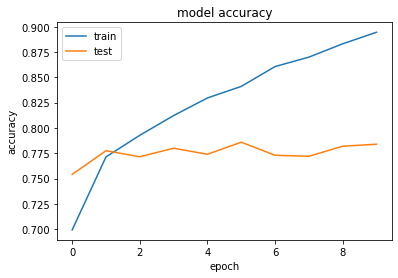

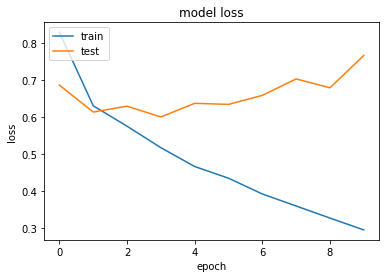

In [125]:
num_epochs=10
def cnn_model1():
    # CNN with max pooling imeplementation 
    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()
    return model

cnn_model=cnn_model1()
cnn_model_compiled,X_train,Y_train=model_compile(cnn_model,word_seq_train,y)
history=cnn_model_compiled.fit(X_train,y,epochs=num_epochs,validation_split=0.20)
history_plot(history)
    

##    Trying Hyperparameters

Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 250

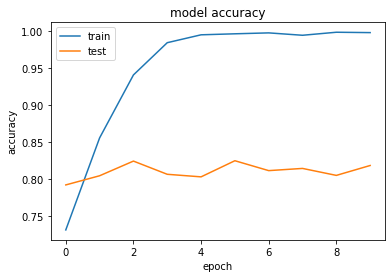

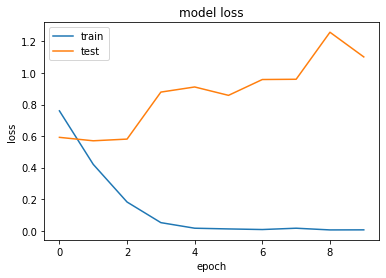

In [22]:
def cnn_model2():
    # CNN with max pooling imeplementation 
    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()
    return model
cnn_model21=cnn_model2()
cnn_model2_compiled,X_train,Y_train=model_compile(cnn_model21,word_seq_train,y)
history=cnn_model2_compiled.fit(X_train,y,epochs=num_epochs,validation_split=0.20)
history_plot(history)


## Another CNN Architecture

## Adding Layer Normalization 

training CNN ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
layer_normalization (LayerNo (None, 300, 300)          600       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 64)           134464    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 150, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6

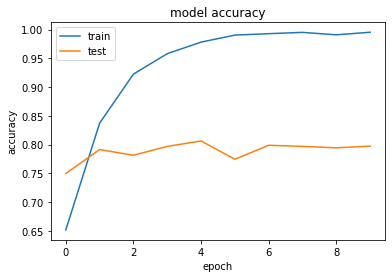

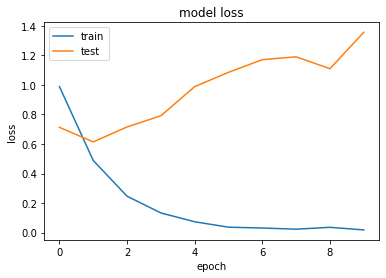

In [23]:
def cnn_model3():
    
    #CNN architecture
    print("training CNN ...")
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(layers.LayerNormalization())
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Dense(6, activation='softmax'))  #multi-label (k-hot encoding)

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.summary()
    return model


cnn_model3=cnn_model3()
cnn_model3_compiled,X_train,Y_train=model_compile(cnn_model3,word_seq_train,y)

history=cnn_model3_compiled.fit(X_train,y,epochs=num_epochs,validation_split=0.20)

history_plot(history)


### BiLSTM  model

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
layer_normalization_2 (Layer (None, 300, 300)          600       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_65 (Dense)             (None, 6)                 774       
Total params: 6,188,254
Trainable params: 6,188,254
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


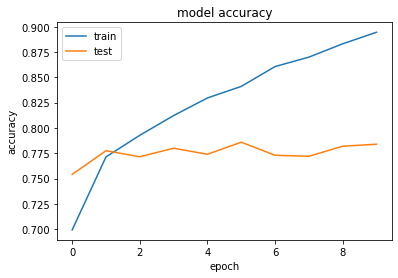

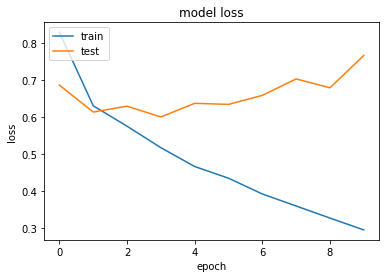

In [126]:
def bilstm_model1():
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(layers.LayerNormalization())
    model.add(SpatialDropout1D(0.9))
    model.add(Bidirectional(LSTM(64, dropout=0.7, recurrent_dropout=0.7)))

    model.add(Dense(6, activation='softmax'))
    model.summary()
    return model

bilstm_model1=bilstm_model1()
bilstm1_compiled,X_train,Y_train=model_compile(bilstm_model1,word_seq_train,y)
# history=bilstm1_compiled.fit(X_train,y,epochs=5,validation_split=0.20)

history_plot(history)
# define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]
# history = model.fit(word_seq_train, y, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)],verbose=1)

## Kfold 

In [25]:

from sklearn.model_selection import KFold
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
stop_words=stopwords.words('english')
from tqdm import tqdm
lemma = WordNetLemmatizer()
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder

In [41]:
# max_seq_len=300

# print('training word seq :\n', word_seq_train[1],'\n')

le=LabelEncoder()
y_encoded=le.fit_transform(label_df['category'].values)
print('labels encoded shape',y_encoded.shape)

x_train,x_test,y_train,y_test=train_test_split(word_seq_train,y,test_size=0.2)

# X_pad = pad_sequences(x_train, maxlen=max_seq_len)
# X_test_pad = pad_sequences(x_test, maxlen=max_seq_len)

# print(' label train seq padded',X_pad[1])
print('seq shape',word_seq_train.shape)
print('unlabed(None)seq shape',word_seq_test.shape)
print('labels shape -- y',y.shape)

print('training seq shape  --x_train:',x_train.shape)
print('testing seq shape -- x_test:',x_test.shape)

print('category train label shape -- y_train:',y_train.shape)
print('category test label shape -- y_test',y_test.shape)

# print('padded train seq shape  -- X_pad: ',X_pad.shape)
# print('padded unlabed test seq shape  -- X_pad: ',X_pad.shape)




labels encoded shape (10065,)
seq shape (10065, 300)
unlabed(None)seq shape (10123, 300)
labels shape -- y (10065, 6)
training seq shape  --x_train: (8052, 300)
testing seq shape -- x_test: (2013, 300)
category train label shape -- y_train: (8052, 6)
category test label shape -- y_test (2013, 6)


In [176]:
kf = KFold(n_splits=3, shuffle=True)

X_fold = list()
y_fold = list()

for _, fold in kf.split(x_train):
    
    X_fold.append(x_train[fold])
    y_fold.append(y_train[fold])
    
X_fold = np.array(X_fold)
y_fold = np.array(y_fold)

# The 0th fold will be our known labeled, the rest folds are assumed to be unlabeled
X_train1 = X_fold[0]
y_train1 = y_fold[0]
print('folded train data X_train1: ', X_train1.shape)
print('folded train labels y_train1: ', y_train1.shape)


folded train data X_train1:  (2684, 300)
folded train labels y_train1:  (2684, 6)


In [149]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

def create_model():
    # CNN with max pooling imeplementation 
    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(6))
    model.add(Activation('softmax'))
    model.summary()
    
    try:
        with tf.device('/device:GPU:0'):
            model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    except RuntimeError as e:
          print(e)
    return model

In [150]:

model = create_model()


Build model...
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_67 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_34 (Glo (None, 250)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_68 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_66 (Activation)   (None, 25

In [177]:
print('X_train_shape before training',X_train.shape)
print('X_train1 shape b4 training',X_train1.shape)
print('Y_train1.shape',y_train1.shape)
model= create_model()
model.fit(X_train1[:-2000], y_train1[:-2000], epochs=10,validation_data=(X_train1[-2000:], y_train1[-2000:]), shuffle=True, verbose=1)



X_train_shape before training (10065, 300)
X_train1 shape b4 training (2684, 300)
Y_train1.shape (2684, 6)
Build model...
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_91 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_46 (Glo (None, 250)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_92 (Dropout)         (None, 250)               0       

In [178]:
predictions = model.predict(X_fold[1])
print('predictions',predictions[1])


predictions [9.9763572e-01 3.1042429e-05 1.1241188e-04 2.2152339e-03 4.4081303e-06
 1.1753170e-06]


In [181]:
def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
#         print(prediction)
        if (prediction.all() > 0.95 or prediction.all()<0.05):
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
        
    return np.array(X_new), np.array(y_new)



In [182]:
X_new, y_new = get_new_train_data(predictions, 1)
print('X_new shape before shuffle',X_new.shape)
print('y_new shape before shuffle',y_new.shape)

# print('X_new',X_new[:2])
print('y_NEW\n',y_new[:10])

print('new train data after predictions {} and labels {}'.format(X_new.shape,y_new.shape))
# print('X_train1',X_train1[1])
print('X_train1.shape',X_train1.shape)
print('Y_train1',y_train1)



X_new shape before shuffle (2684, 300)
y_new shape before shuffle (2684,)
y_NEW
 [0 0 1 0 1 3 0 0 0 3]
new train data after predictions (2684, 300) and labels (2684,)
X_train1.shape (2684, 300)
Y_train1 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [183]:
print(y_new1.shape)

(2684, 6)


In [184]:
def join_shuffle(X_train, y_train, X_new, y_new):
    X_train = np.vstack((X_train, X_new))
    
    y_train = np.vstack((y_train, y_new))
    print('y_train shape while shuffling',y_train.shape)
    print(y_train)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    return X_train[indices], y_train[indices]

In [185]:
print(y_train1[0])
print('y_new categorical',y_new)

y_new1=np_utils.to_categorical(y_new, num_classes=6)
print(y_new1.shape)

[1. 0. 0. 0. 0. 0.]
y_new categorical [0 0 1 ... 0 0 0]
(2684, 6)


In [186]:
X_train2, y_train2 = join_shuffle(X_train1, y_train1, X_new, y_new1)
print('y_train2\n',y_train2.shape)


y_train shape while shuffling (5368, 6)
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
y_train2
 (5368, 6)


In [166]:
print('shuffled train data X_train2',X_train2.shape)
print('shuffled test data y_train2',y_train2.shape)
# y_train2=np_utils.to_categorical(y_train2, num_classes=6)
print(y_train2.shape,'y_train_shape')


shuffled train data X_train2 (5368, 300)
shuffled test data y_train2 (5368, 6)
(5368, 6) y_train_shape


In [187]:

print('shuffle test data y_train2 categorizing',y_train2.shape)
print('y_new',y_new[10])
print('y_train2\n',y_train2[:2])

# print([category_list[i] for i in y_new[:1]])
# 

model = create_model()
model.fit(X_train2[:-2000], y_train2[:-2000], epochs=10, 
          validation_data=(X_train2[-2000:], y_train2[-2000:]))

# Predict samples in fold 2
predictions = model.predict(X_fold[2])



shuffle test data y_train2 categorizing (5368, 6)
y_new 1
y_train2
 [[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Build model...
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_93 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_47 (Glo (None, 250)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_94 (Dropout)         (None, 250)               0   

In [188]:

# Filter out samples in fold 2
X_new, y_new = get_new_train_data(predictions, 2)
print('label_new_updated shape y_new',y_new.shape)
print('y_new',y_new)
# Concatenate new data to X_train and y_train
y_new=np_utils.to_categorical(y_new, num_classes=6)

X_train3, y_train3 = join_shuffle(X_train2, y_train2, X_new, y_new)
print('y_train3',y_train3)
# y_train3=np_utils.to_categorical(y_train3, num_classes=6)
print(y_train3[-12:])

label_new_updated shape y_new (2684,)
y_new [1 0 3 ... 1 3 1]
y_train shape while shuffling (8052, 6)
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
y_train3 [[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


In [189]:

model.fit(X_train3, y_train3, 
          validation_data=(x_test, y_test),epochs=10)

Epoch 1/10
252/252 [==============================] - 45s 178ms/step - loss: 0.0831 - accuracy: 0.9153 - val_loss: 0.2168 - val_accuracy: 0.7789
Epoch 2/10
252/252 [==============================] - 44s 174ms/step - loss: 0.0233 - accuracy: 0.9800 - val_loss: 0.2727 - val_accuracy: 0.7705
Epoch 3/10
252/252 [==============================] - 44s 173ms/step - loss: 0.0067 - accuracy: 0.9953 - val_loss: 0.3513 - val_accuracy: 0.7750
Epoch 4/10
252/252 [==============================] - 44s 176ms/step - loss: 0.0026 - accuracy: 0.9983 - val_loss: 0.3775 - val_accuracy: 0.7700
Epoch 5/10
252/252 [==============================] - 44s 175ms/step - loss: 0.0020 - accuracy: 0.9990 - val_loss: 0.4212 - val_accuracy: 0.7645
Epoch 6/10
252/252 [==============================] - 44s 177ms/step - loss: 8.8971e-04 - accuracy: 0.9996 - val_loss: 0.4678 - val_accuracy: 0.7620
Epoch 7/10
252/252 [==============================] - 50s 200ms/step - loss: 3.8311e-04 - accuracy: 0.9999 - val_loss: 0.4843 

## CNN model check 

In [ ]:
cnn_model2()

In [174]:
num_epochs=20
cnn_model21=cnn_model2()


Build model...
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_85 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_43 (Glo (None, 250)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_86 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_84 (Activation)   (None, 25

In [175]:
def kfolded_model(X_train1,y_train1,x_test,y_test):
    
    cnn_model21=cnn_model2()
    cnn_model21_compiled,X_folded,y_folded=model_compile(cnn_model21,X_train1,y_train1)
    
    cnn_model21_compiled.fit(X_folded[:-1000], y_folded[:-1000], epochs=num_epochs,validation_data=(X_folded[-1000:], y_folded[-1000:]), shuffle=True, verbose=1)

    cnn2_predictions1 = cnn_model21.predict(X_fold[1])
    print('predictions',cnn2_predictions1)

    X_new, y_new = get_new_train_data(cnn2_predictions1, 2)
    y_new=np_utils.to_categorical(y_new, num_classes=6)
    
    
    X_train2_shuffle, y_train2_shuffle = join_shuffle(X_folded, y_folded, X_new, y_new)
    print('new train data after predictions {} and labels {}'.format(X_new.shape,y_new.shape))
    print('shuffle train data X_train2',X_train2_shuffle.shape)
    print('shuffle test data y_train2',y_train2_shuffle.shape)

#     y_train2_shuffle=np_utils.to_categorical(y_train2_shuffle, num_classes=6)
    print('shuffle test data y_train2 categorizing',y_train2_shuffle.shape)

    
    cnn_model21 = cnn_model2()
    cnn_model21_compiled,X_train2_shuffle,y_train2_shuffle=model_compile(cnn_model21,X_train2_shuffle,y_train2_shuffle)
    
    cnn_model21.fit(X_train2_shuffle[:-2000], y_train2_shuffle[:-2000], epochs=num_epochs, 
          validation_data=(X_train2_shuffle[-2000:], y_train2_shuffle[-2000:]))

    # Predict samples in fold 2
    cnn2_predictions2= cnn_model21.predict(X_fold[1])
    
    # Filter out samples in fold 2
    X_new, y_new = get_new_train_data(cnn2_predictions2, 3)
    print('label_new_updated shape y_new',y_new.shape)
    y_new=np_utils.to_categorical(y_new, num_classes=6)
    
    # Concatenate new data to X_train and y_train
    X_train3_shuffle, y_train3_shuffle = join_shuffle(X_train2_shuffle, y_train2_shuffle, X_new, y_new)
#     y_train3_shuffle=np_utils.to_categorical(y_train3_shuffle, num_classes=6)

    cnn_model21=cnn_model2()
    cnn_model2_compiled,X_train3_shuffle,y_train3_shuffle=model_compile(cnn_model21,X_train3_shuffle,y_train3_shuffle)
            
    history=cnn_model2_compiled.fit(X_train3_shuffle, y_train3_shuffle,validation_data=(x_test, y_test),epochs=num_epochs)
    
    history_plot(history)

    
kfolded_model(X_train1,y_train1,x_test,y_test)

Build model...
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 300, 300)          6000000   
_________________________________________________________________
dropout_87 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 298, 250)          225250    
_________________________________________________________________
global_max_pooling1d_44 (Glo (None, 250)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_88 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_86 (Activation)   (None, 25

Epoch 10/20
106/106 [==============================] - 20s 187ms/step - loss: 0.0173 - accuracy: 0.9962 - val_loss: 2.6966 - val_accuracy: 0.4660
Epoch 11/20
106/106 [==============================] - 19s 184ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 2.8197 - val_accuracy: 0.4700
Epoch 12/20
106/106 [==============================] - 20s 189ms/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 2.9085 - val_accuracy: 0.4870
Epoch 13/20
106/106 [==============================] - 19s 182ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 3.0845 - val_accuracy: 0.4215
Epoch 14/20
106/106 [==============================] - 19s 183ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 3.1306 - val_accuracy: 0.4915
Epoch 15/20
106/106 [==============================] - 20s 191ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 3.0587 - val_accuracy: 0.4635
Epoch 16/20
106/106 [==============================] - 20s 190ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 3.1378 -

IndexError: index 3 is out of bounds for axis 0 with size 3

# Overfitting Observed



## Excluding Embedded weights
### embed_dim,weights=[embedding_matrix] : but getting worst

## Tryied L2 regularizer to add some penalty 

###  Checking with Different Folds
###  CNN models is use with name change cnn_model2

### Some Corrections and verifcation required while encoding labels from each steps


In [ ]:
from keras.regularizers import l2,l1_l2

In [ ]:
def get_new_train_data(predictions, fold_n):
    X_new = list()
    y_new = list()
    
    for i, prediction in enumerate(predictions):
#         print(prediction)
        if (prediction.all() > 0.85 or prediction.all()<0.05):
            X_new.append(X_fold[fold_n][i])
            y_new.append(np.argmax(prediction))
        
    return np.array(X_new), np.array(y_new)

In [ ]:
num_classes=100
def cnn_model2():
    # CNN with max pooling imeplementation 
    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(nb_words, embed_dim,weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(6,kernel_regularizer='l2'))
    model.add(Activation('softmax'))
    model.summary()
    return model


In [ ]:
num_epochs=50

In [ ]:
def kfolded_model(X_train1,y_train1,x_test,y_test):
    cnn_model21=cnn_model2()
    cnn_model21_compiled,X_folded,y_folded=model_compile(cnn_model21,X_train1,y_train1)
    cnn_model21_compiled.fit(X_folded[:-1500], y_folded[:-1500], epochs=num_epochs,validation_data=(X_folded[-1500:], y_folded[-1500:]), shuffle=True, verbose=1)

    cnn2_predictions1 = cnn_model21.predict(X_fold[2])
    print('predictions',cnn2_predictions1)

    X_new, y_new = get_new_train_data(cnn2_predictions1, 2)
    X_train2_shuffle, y_train2_shuffle = join_shuffle(X_folded, y_folded, X_new, y_new)

    print('new train data after predictions {} and labels {}'.format(X_new.shape,y_new.shape))
    print('shuffle train data X_train2',X_train2_shuffle.shape)
    print('shuffle test data y_train2',y_train2_shuffle.shape)

    y_train2_shuffle=np_utils.to_categorical(y_train2_shuffle, num_classes=6)
    print('shuffle test data y_train2 categorizing',y_train2_shuffle.shape)

    
    cnn_model21 = cnn_model2()
    cnn_model21_compiled,X_train2_shuffle,y_train2_shuffle=model_compile(cnn_model21,X_train2_shuffle,y_train2_shuffle)
    
    cnn_model21.fit(X_train2_shuffle[:-1500], y_train2_shuffle[:-1500], epochs=num_epochs, 
          validation_data=(X_train2_shuffle[-1500:], y_train2_shuffle[-1500:]))

    # Predict samples in fold 2
    cnn2_predictions2= cnn_model21.predict(X_fold[2])

    # Filter out samples in fold 2
    X_new, y_new = get_new_train_data(cnn2_predictions2, 2)
    print('label_new_updated shape y_new',y_new.shape)

    # Concatenate new data to X_train and y_train
    X_train3_shuffle, y_train3_shuffle = join_shuffle(X_train2_shuffle, y_train2_shuffle, X_new, y_new)
    y_train3_shuffle=np_utils.to_categorical(y_train3_shuffle, num_classes=6)

#     cnn_model21=cnn_model2()
    cnn_model2_compiled,X_train3_shuffle,y_train3_shuffle=model_compile(cnn_model21,X_train3_shuffle,y_train3_shuffle)
            
    history=cnn_model2_compiled.fit(X_train3_shuffle, y_train3_shuffle,validation_data=(x_test, y_test),epochs=num_epochs)
    
    history_plot(history)

    
kfolded_model(X_train1,y_train1,x_test,y_test)